In [130]:

import os, math, time, sys, numpy as np, copy, datetime

import pdb

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=RuntimeWarning) 


from scipy.optimize import least_squares

from astropy.coordinates import SkyCoord
import astropy.units as u, fileinput
from astropy.time import Time as aTime

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy.linalg import inv

from itertools import product


In [3]:
def splitt(old_list):
    #splits the list entries into sublists
    new_list=[]
    for i in old_list:
        new_list+=[i.split()]
    return np.array(new_list)

def get_file(path):
    #opens and external file and makes it into a list
    fopen = path
    f=open(fopen, 'r+')
    g=list(f)
    g=map(lambda s: s.strip(), g)
    return np.array(list(g))

class calibrator:
    def __init__(self,sid,name,x,y,index):
        self.x     = x  # deg
        self.y     = y  # deg
        self.sid   = sid  # 
        self.name  = name        
        self.index = index

def get_ant(data):
    antennas = {}
    for row in data.table('AN', 0):
        antennas[row.nosta] = row.anname[0:2]
    return antennas

def rad2deg(rad):
    return rad*180./np.pi

def replace(file, searchExp, replaceExp):
    for line in fileinput.input(file, inplace=1):
        line = line.replace(searchExp, replaceExp)
        sys.stdout.write(line)

In [75]:
calibs = np.array([
    [ 6, 'G327.40+0.44','15:49:19.50 -53:45:13.9'], 
    [ 7, 'J1603-4904','16:03:50.6845 -49:04:05.505'], 
    [ 8, 'J1600-5811','16:00:12.3775 -58:11:02.969'],
    [ 9, 'J1542-5838','15:42:45.6448 -58:38:32.725'],
    [10, 'J1515-5559','15:15:12.6729 -55:59:32.838'],
    [11, 'J1534-5351','15:34:20.6607 -53:51:13.423'],
    [12, 'J1549-5235','15:49:11.1948 -52:35:02.943']
])

t = SkyCoord(calibs[0,2:][0],unit=(u.hourangle,u.deg),frame='icrs')
#c = np.array([SkyCoord(s,unit=(u.hourangle,u.deg),frame='icrs') for s in calibs[1:,2:]])
quas = {}
for i in range(len(calibs)):
    c = SkyCoord(calibs[i][-1],unit=(u.hourangle,u.deg),frame='icrs')
    x,y = (t.ra.deg-c.ra.deg)*np.cos(t.dec.radian),(t.dec.deg-c.dec.deg)
    q = calibrator(calibs[i][0],calibs[i][1],x,y,i)
    quas.update({q.sid:q})

replace('sn.tbout',"'INDE'",'-999.9')

with open('sn.tbout') as w:
    mvtbout = w.readlines()

head = np.where(np.array(mvtbout) == '***BEGIN*PASS***\n')[0][0]+1
data = np.array([s.split() for s in mvtbout[head:-1]])

box = (1,3,4,12,13)
tmp,tmp,tmp, real0, imag0 = data[:,box].T
vis0 = np.array(real0,dtype=float)+np.array(imag0,dtype=float)*complex(0,1)
inde = abs(vis0)>2  #finding INDE

fday0, src_num1, ant_num1, real1, imag1 = data[:,box][~inde].T # remove INDE
vis1  = np.array(real1,dtype=float)+np.array(imag1,dtype=float)*complex(0,1)
fday1 = np.array([s.replace('D','E') for s in fday0],dtype='float')

dt = 10

ants = np.delete(np.unique(ant_num1),0)
sids = np.unique(src_num1)
# every minute
rtime = np.unique(fday1) #np.arange(fday1[0],fday1[-1],1/(24*60))[1:-1]  


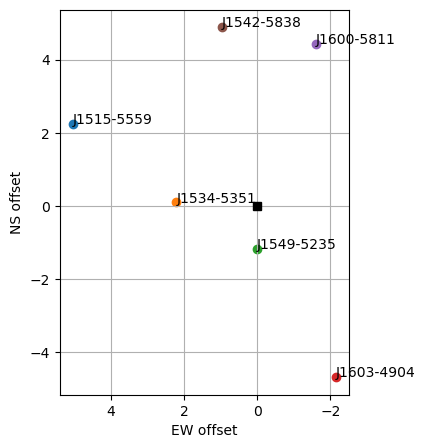

In [76]:
fig, ax = plt.subplots(1,figsize=(5,5))
ax.plot(0,0,'ks')#,label=cvelsource[0])
for s in sids:
    ax.scatter(quas[s].x,quas[s].y)
    ax.text(quas[s].x,quas[s].y,s=quas[s].name)
ax.grid('True')
ax.invert_xaxis()
ax.set_xlabel('EW offset')
ax.set_ylabel('NS offset')
ax.set_aspect('equal')

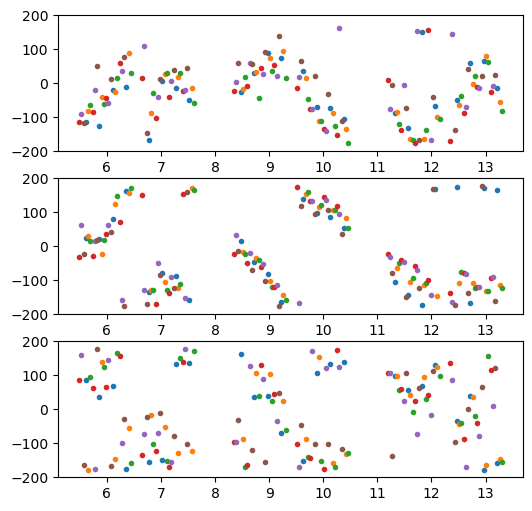

In [77]:
fig, ax = plt.subplots(len(ants),1,figsize=(2*3,3*(len(ants)-1)))
for nant in range(len(ants)):
    for nsrc in range(len(sids)):
        indx = (ant_num1==ants[nant])*(src_num1==sids[nsrc])
        ax[nant].plot(24*fday1[indx],
                      57.2*np.angle(vis1[indx]),'.')
    ax[nant].set_ylim(-200,200)
#fig.savefig('/Users/lucas3/spirals/testing/phase_vs_time.pdf',bbox_inches='tight')

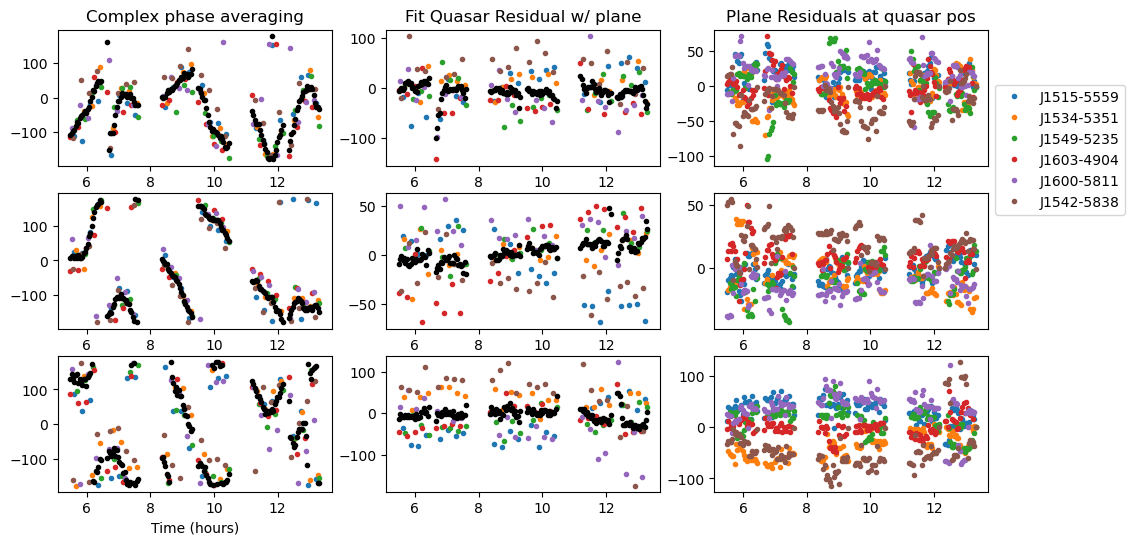

In [255]:
dt = 8

refant = '1'
T,P,R = {},{},[]
for nant in range(len(ants)):
    R.append({})
    for sid in sids:
        R[nant].update({sid:np.ones(shape=rtime.shape)*np.nan})
# get the average
c_mean = np.zeros(shape=(len(rtime),len(ants)))*complex(0,0)
for i in range(len(rtime)):
    low,high=rtime[i]-dt/(24*60),rtime[i]+dt/(24*60)
    for nant in range(len(ants)):
        indx = (ant_num1==ants[nant])*(fday1>=low)*(fday1<=high)
        # complex mean
        c_mean[i,nant] = complex(vis1[indx].real.mean(),vis1[indx].imag.mean())

# get the residual
rvis = copy.deepcopy(vis1)
for i in range(len(vis1)):
    # get time stamp for time
    indx_t = rtime == fday1[i]
    # get antenna index
    if ant_num1[i]==refant: continue
    indx_a = np.where(ants==ant_num1[i])
    #
    p = np.angle(vis1[i])-np.angle(c_mean[indx_t,indx_a])    
    # residual visibility
    rvis[i] = complex(np.cos(p),np.sin(p))

# move along in time and fit plane to residual
for nant in range(len(ants)):
    t,p,a,b = [],[],[],[]
    for i in range(len(rtime)):
        low,high=rtime[i]-dt/(24*60),rtime[i]+dt/(24*60)
        indx = (ant_num1==ants[nant])*(fday1>=low)*(fday1<=high)
        # now we need to get the x, y and z for this time slice
        M = np.matrix([(1,quas[s].x,quas[s].y) for s in src_num1[indx]])
        if not len(M)<2:
            # calculate design matrix
            D = inv(M.T * M)*M.T
            # get solutions
            lam = D*np.matrix(np.angle(rvis[indx])).T  # centre p, ra slope, dec slope
            # append time, phase and slopes
            t.append(rtime[i])
            p.append(lam[0].tolist()[0][0])
            a.append(lam[1])
            b.append(lam[2])
            # calculate residuals
            foo = src_num1[indx]
            f_phas  = np.array((M.dot(lam)).T).squeeze()
            r_phas = (f_phas - np.angle(rvis[indx])) # residual phase
            #print(r_phas)
            r_phas[r_phas >= np.pi] += -2*np.pi 
            r_phas[r_phas < -np.pi] +=  2*np.pi
            for j in range(len(src_num1[indx])):
                R[nant][foo[j]][i] = r_phas[j]
        else:
            # append time and null phase (keep solutions the same length)
            t.append(rtime[i])
            p.append(np.nan)
    T.update({ants[nant]:t})
    P.update({ants[nant]:np.array(p)})

fig, ax = plt.subplots(len(ants),3,figsize=(4*3,3*(len(ants)-1)))
for nant in range(len(ants)):
    for nsrc in range(len(sids)):
        indx = (ant_num1==ants[nant])*(src_num1==sids[nsrc])
        ax[nant,0].plot(24*fday1[indx],57.2*np.angle(vis1[indx]),'.')
        ax[nant,1].plot(24*fday1[indx],57.2*np.angle(rvis[indx]),'.')
        if nant==0: 
            ax[nant,2].plot(24*rtime,57.2*R[nant][sids[nsrc]],'.',label=quas[sids[nsrc]].name)
        else: 
            ax[nant,2].plot(24*rtime,57.2*R[nant][sids[nsrc]],'.')
    ax[nant,0].plot(24*rtime,57.2*np.angle(c_mean[:,nant]),'k.')
    ax[nant,1].plot(24*rtime,57.2*P[ants[nant]],'k.')

ax[0,0].set_title('Complex phase averaging');
ax[0,1].set_title('Fit Quasar Residual w/ plane');
ax[0,2].set_title('Plane Residuals at quasar pos');
ax[-1,0].set_xlabel('Time (hours)');
fig.legend(bbox_to_anchor=(0.9, 0.8), loc='upper left');
#for AX in ax.flatten():
#    AX.set_ylim(-200,200)
#fig.savefig('/Users/lucas3/spirals/testing/complex_avg.pdf',bbox_inches='tight')

In [302]:
# can we fit a position error? lets try
# baselines:
X1= -3753442.7457;  Y1=  3912709.7530;  Z1= -3348067.6095; l1= np.arctan2(Y1,X1)*57.2
X2= -3949990.8402;  Y2=  2522421.2190;  Z2= -4311707.9989; l2= np.arctan2(Y2,X2)*57.2
X3= -4147354.6913;  Y3=  4581542.3772;  Z3= -1573303.1565; l3= np.arctan2(Y3,X3)*57.2
X4= -5115425.8180;  Y4=   477880.2480;  Z4= -3767042.0550; l4= np.arctan2(Y4,X4)*57.2
#X= -2388896.1890;  Y=  5043350.0019;  Z= -3078590.8037

start = datetime.datetime(2021,8,13)

sid_t0 = aTime(start).sidereal_time('mean',longitude=0).value

def pos_phase(p,bx,by,bz,h,d):
    return 1/2e8*(p[0]*np.cos(d)*( bx*np.sin(h)+by*np.cos(h) )+p[1]*( -bx*np.cos(h)*np.sin(d) + by*np.sin(h)*np.sin(d) +  bz*np.cos(d) )) + p[2]

def res_pos(p,bx,by,bz,h,d,y):
    return pos_phase(p,bx,by,bz,h,d) - y 


array([ 4.40606109, -2.87589123, -0.59888369])

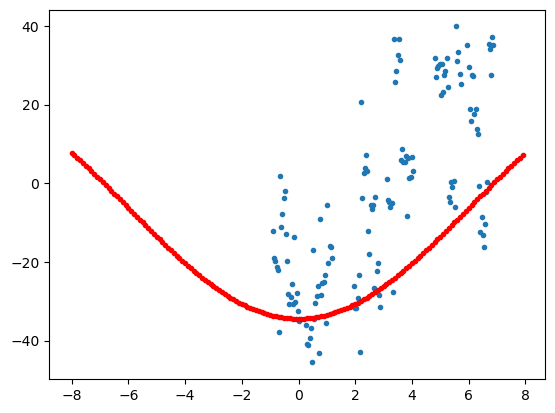

In [318]:
# hourangle

#LST =        GST              + LAT
t4 = (sid_t0 + rtime*24-24) + l4/15.  # hours
# HA = LST - RA
h4 = t4 - 15.5

fig, ax = plt.subplots(1)
ax.plot(h4,(R[2][sids[1]]-lsq.x[-1])*57.2,'.')
bx = (X1 - X4)/3e8*6.7e9
by = (Y4 - Y4)/3e8*6.7e9
bz = (Z1 - Z4)/3e8*6.7e9

nanindx = np.isnan(R[2][sids[1]])
lsq = least_squares(res_pos,[1,1,1],args=(bx,by,bz,h4[~nanindx]*(np.pi/12),-54/57.2,R[2][sids[1]][~nanindx]))
h = np.arange(-8,8,0.1)
p2 = pos_phase([0.0,-4.0,0],bx,by,bz,h*(np.pi/12),-54/57.2)*57.2
ax.plot(h,p2,'r.')
#res_pos([0,0,0],bx,by,bz,h4[~nanindx]/(np.pi/12),-54/57.2,6.7e9,R[2][sids[1]][~nanindx])
lsq.x

In [300]:
bx,by,bz

(30417621.948033337, 0.0, 9357095.94950001)

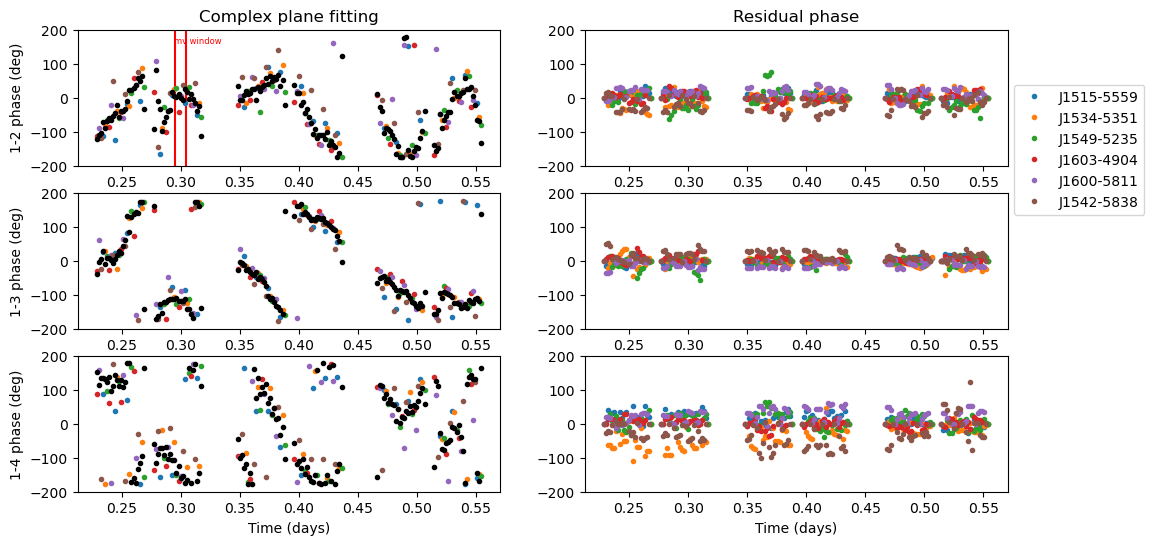

In [122]:
# time to fit real and imaginary planes
# construct a time array starting at start of data-1m every minute to end-1m
# rtime = np.arange(fday1[0],fday1[-1],1/(24*60))[1:-1]
T,P,R = {},{},[{},{},{},{}]
for nant in range(len(ants)):
    for sid in sids:
        R[nant].update({sid:np.ones(shape=rtime.shape)*np.nan})
dt = 7
refant = '1'
# move along in time
for nant in range(len(ants)):
    t,p,a,b = [],[],[],[]
    for i in range(len(rtime)):
        low,high=rtime[i]-dt/(24*60),rtime[i]+dt/(24*60)
        indx = (ant_num1==ants[nant])*(fday1>=low)*(fday1<=high)
        # now we need to get the x, y and z for this time slice
        M = np.matrix([(1,quas[s].x,quas[s].y) for s in src_num1[indx]])
        if not len(M)<2:
            # calculate design matrix
            D = inv(M.T * M)*M.T
            # get solutions
            lam_r = D*np.matrix(vis1[indx].real).T  # real cent, ra slope, dec slope
            lam_i = D*np.matrix(vis1[indx].imag).T  # imag " etc
            # append time and complex phase
            t.append(rtime[i])
            p.append(complex(lam_r[0],lam_i[0]))
            # residual time
            foo = src_num1[indx]
            f_comp  = np.array((M*lam_r)+complex(0,1)*(M*lam_i)).squeeze()  # complex fit
            f_phas  = np.angle(f_comp)    # fit phase
            r_phas = f_phas - np.angle(vis1[indx]) # residual phase
            r_phas[r_phas >  np.pi] += -2*np.pi 
            r_phas[r_phas <= -np.pi] +=  2*np.pi
            for j in range(len(src_num1[indx])):
                R[nant][foo[j]][i] = r_phas[j]
        else:
            # append time and null phase (keep solutions the same length)
            t.append(rtime[i])
            p.append(np.nan)
    T.update({ants[nant]:t})
    P.update({ants[nant]:p})

fig, ax = plt.subplots(len(ants),2,figsize=(4*3,3*(len(ants)-1)))
for nant in range(len(ants)):
    for nsrc in range(len(sids)):
        indx = (ant_num1==ants[nant])*(src_num1==sids[nsrc])
        ax[nant,0].plot(fday1[indx],57.2*np.angle(vis1[indx]),'.')
        if nant==0: 
            ax[nant,1].plot(rtime,57.2*R[nant][sids[nsrc]],'.',label=quas[sids[nsrc]].name)
        else: 
            ax[nant,1].plot(rtime,57.2*R[nant][sids[nsrc]],'.')
    ax[nant,0].plot(rtime,57.2*np.angle(P[ants[nant]]),'k.')
    ax[nant,0].set_ylim(-200,200);
    ax[nant,1].set_ylim(-200,200);
    ax[nant,0].set_ylabel('{}-{} phase (deg)'.format(refant,ants[nant]))
ax[0,-1].set_xlabel('Time (days)')
ax[0,0].set_title('Complex plane fitting');
ax[0,1].set_title('Residual phase');
ax[0,0].vlines(ymin=-201,ymax=201,x=fday1[150]-dt/(24*60),color='r',zorder=1)
ax[0,0].vlines(ymin=-201,ymax=201,x=fday1[150]+dt/(24*60),color='r',zorder=1);
ax[0,0].text(x=fday1[138],y=160,s='mv window',size=6,color='r')
ax[-1,0].set_xlabel('Time (days)');
ax[-1,-1].set_xlabel('Time (days)');
fig.legend(bbox_to_anchor=(0.9, 0.8), loc='upper left');
fig.savefig('/Users/lucas3/spirals/testing/mv_fitting.pdf',bbox_inches='tight')

(-1.1, 1.1)

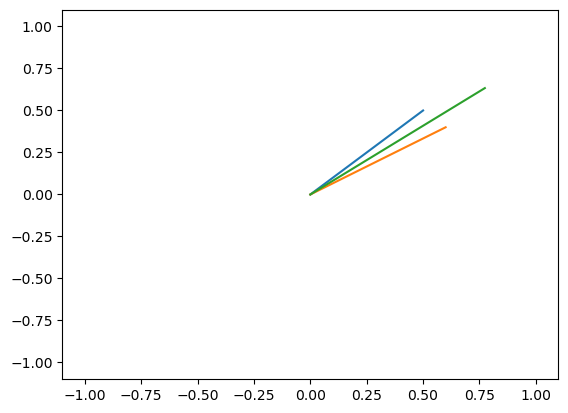

In [123]:
z1 = complex(0.5,0.5)
z2 = complex(0.6,0.4)
z = complex(z1.real+z2.real,z1.imag+z2.imag)
z3 = z/abs(z)
fig, ax = plt.subplots(1)
ax.plot([0,z1.real],[0,z1.imag],'-')
ax.plot([0,z2.real],[0,z2.imag],'-')
ax.plot([0,z3.real],[0,z3.imag],'-')
ax.set_xlim(-1.1,1.1)
ax.set_ylim(-1.1,1.1)

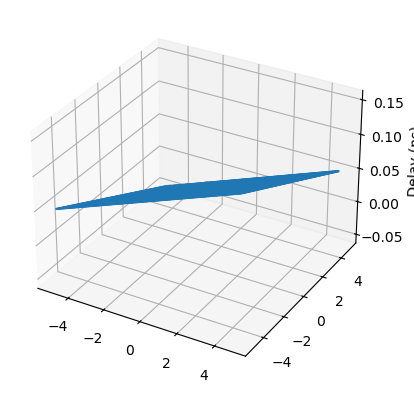

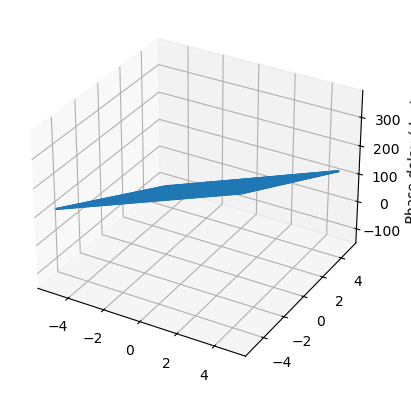

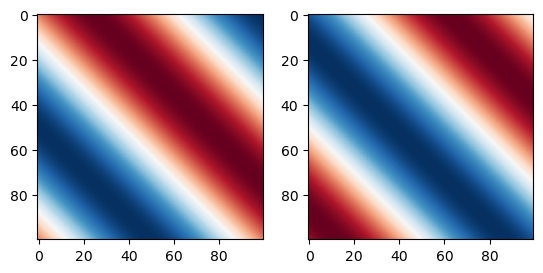

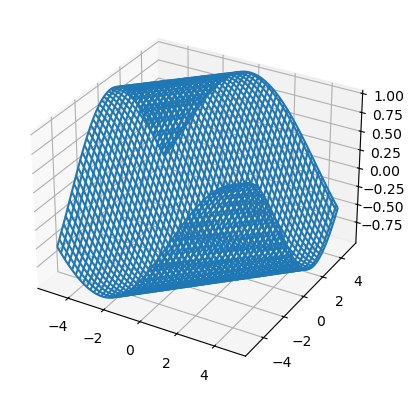

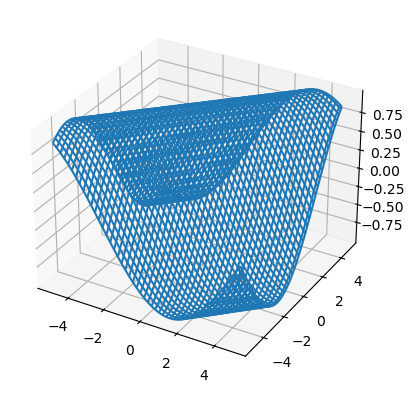

In [48]:
#%matplotlib widget

# lets make a delay plane +/- 0.1n#
tau0 = 0.05  #np.random.uniform(-0.01,0.01)
A    = 0.01 #np.random.uniform(-0.1,0.1)/5.
B    =-0.01 #np.random.uniform(-0.1,0.1)/5.
x = np.arange(-5,5,0.1)
X,Y  = np.meshgrid(x,x) 

xi = np.random.uniform(-4,4,6)
yi = np.random.uniform(-4,4,6)

tau  = tau0 + A*X  + B*Y
taui = tau0 + A*xi + B*yi
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(X,Y,tau,zorder=98)
ax.scatter3D(xi,yi,taui,'.',color='r',zorder=99);
ax.set_zlabel('Delay (ns)')
#ax.set_zlim(-3,3)

ph  = tau*2*np.pi*6.7e9/1e9
phi = taui*2*np.pi*6.7e9/1e9

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(X,Y,57.2*ph,zorder=98)
ax.scatter3D(xi,yi,57.2*phi,'.',color='r',zorder=99)
ax.set_zlabel('Phase delay (deg)')

re   = np.cos(ph )
im   = np.sin(ph )
rei  = np.cos(phi)
imi  = np.sin(phi)

fig, ax = plt.subplots(1,2)
ax[0].imshow(re,vmin=-1,vmax=1,cmap='RdBu')
ax[1].imshow(im,vmin=-1,vmax=1,cmap='RdBu')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(X,Y,re,zorder=98)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(X,Y,im,zorder=98)

# New unwrapping programme

In [124]:
# tbd